<a href="https://colab.research.google.com/github/Cons1gl1er3/SMS_spam_detection/blob/main/Source_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SETTING UP**

## **Data retrieving and libraries installing**

In [4]:
# Uncomment this if you have any uninstalled libraries
#!pip install numpy
#!pip install matplotlib
#!pip install pandas
#!pip install sklearn
#!pip install nltk
#!pip install hyperopt

## **Import libraries and data preprocessing**

In [1]:
# Basic importation
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Validation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, cross_val_score

# Pipeline
from sklearn.pipeline import Pipeline

# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

# Preprocessing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk import tokenize
import string

# Data Transformation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Train - Test Split
from sklearn.model_selection import train_test_split

# Hyperparameter
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials

# Data visualization
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vanht\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vanht\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Read in the input
data1 = pd.read_csv('Dataset/spam1.csv', encoding="ISO-8859-1")
data2 = pd.read_csv('Dataset/spam2.csv', encoding="ISO-8859-1")

In [3]:
# Drop null columns
data1.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1, inplace = True)
data1.columns = ['labels', 'text']
data2 = data2[data2['labels'] == 'spam']
data = pd.concat([data1, data2])
data['label_enc'] = data['labels'].map({'ham':0,'spam':1})
data.drop(['labels'], axis = 1, inplace = True)

# Display the data
display(data.head())

,text,label_enc
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


# **DATA ANALYZING AND FEATURE EXTRACTION**

### **Feature extraction**

In [4]:
# Preprocess
SW = stopwords.words("english") + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']

def preprocess_text(text):

    """
    String text in input, remove its punctuation and stopwords.
    Return the cleaned text
    """
    text = text.strip()
    text = text.lower()

    words = tokenize.word_tokenize(text)

    ps = PorterStemmer()

    filter_words = [ps.stem(word) for word in words if word not in SW and word.isalnum()]

    transformed_text = " ".join(filter_words)

    return transformed_text

data["cleaned text"] = data["text"].apply(preprocess_text)

# Count Vectorizer
Vect = CountVectorizer()

X_vect = Vect.fit_transform(data["cleaned text"]).toarray()
y_vect = data['label_enc']

# TF-IDF
Tfidf = TfidfVectorizer()
X_tfidf = Tfidf.fit_transform(data["cleaned text"]).toarray()
y_tfidf = data['label_enc']

# Train, test data
X, y = data['cleaned text'], data['label_enc']


# **Hyperparameter Tuning**


## **Using Count Vectorizer**

### **RANDOM FOREST**

In [ ]:
# Uncomment the code below to run the hyperparameter function (time consuming)

space1 = {
    "n_estimators": hp.uniformint("n_estimators", 50, 300),
    "criterion": hp.choice("criterion", ["gini", "entropy"]),
    "max_depth": hp.uniformint("max_depth", 1, 70)
}

def hyperparameter_tuning1_vect(params):
    clf = RandomForestClassifier(**params, n_jobs=-1)
    acc = cross_val_score(clf, X_vect, y_vect, scoring="accuracy").mean()
    return {"loss": -acc, "status": STATUS_OK}

trials1_vect = Trials()

best1_vect = fmin(
    fn=hyperparameter_tuning1_vect,
    space = space1,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials1_vect
)

print("Best: {}".format(best1_vect))


100%|██████████| 50/50 [53:43<00:00, 64.48s/trial, best loss: -0.984491541136735]
Best: {'criterion': 0, 'max_depth': 69.0, 'n_estimators': 84.0}


In [ ]:
Random_Forest_vect = RandomForestClassifier(n_estimators = 84, max_depth = 69, criterion = 'gini', random_state = 1)

### **SUPPORT VECTOR MACHINE**

In [ ]:
# Uncomment the code below to run the hyperparameter function (time consuming)
space2 = {
    "gamma": hp.choice("gamma", [0.1, 1, 10, 100, 1000]),
    "kernel": hp.choice("kernel", ["rbf", "linear"]),
    "C": hp.choice("C", [0.1, 1, 10, 100, 1000]),
}

def hyperparameter_tuning2(params):
    clf = SVC(**params)
    acc = cross_val_score(clf, X_vect, y_vect, scoring="accuracy", cv=3).mean()
    return {"loss": -acc, "status": STATUS_OK}

trials2_vect = Trials()

best = fmin(
    fn=hyperparameter_tuning2,
    space = space2,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials2_vect
)

print("Best: {}".format(best))

100%|██████████| 50/50 [2:13:39<00:00, 160.40s/trial, best loss: -0.9963598328308554]
Best: {'C': 4, 'gamma': 0, 'kernel': 0}


In [ ]:
SVM_vect = SVC(C = 1000, gamma = 0.1, kernel = 'rbf', random_state = 1)

### **Naive Bayes**

In [ ]:
# Uncomment the code below to run the hyperparameter function (time consuming)
space3 = {
    "alpha": hp.uniform("alpha", 1, 10)
}

def hyperparameter_tuning3_vect(params):
    clf = MultinomialNB(**params)
    acc = cross_val_score(clf, X_vect, y_vect, scoring="accuracy", cv=5).mean()
    return {"loss": -acc, "status": STATUS_OK}

trials3_vect = Trials()

best3_vect = fmin(
    fn=hyperparameter_tuning3_vect,
    space = space3,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials3_vect
)

print("Best: {}".format(best3_vect))

100%|██████████| 100/100 [03:45<00:00,  2.25s/trial, best loss: -0.9770525772472615]
Best: {'alpha': 1.0159496223076434}


In [ ]:
Naive_Bayes_vect = MultinomialNB(alpha = 1.0159496223076434)

## **Using TF-IDF**

### **RANDOM FOREST**

In [ ]:
# Uncomment the code below to run the hyperparameter function (time consuming)
space1 = {
    "n_estimators": hp.uniformint("n_estimators", 50, 300),
    "criterion": hp.choice("criterion", ["gini", "entropy"]),
    "max_depth": hp.uniformint("max_depth", 1, 100)
}

def hyperparameter_tuning1_tfidf(params):
    clf = RandomForestClassifier(**params, n_jobs=-1)
    acc = cross_val_score(clf, X_tfidf, y_tfidf, scoring="accuracy").mean()
    return {"loss": -acc, "status": STATUS_OK}

trials1_tfidf = Trials()

best1_tfidf = fmin(
    fn=hyperparameter_tuning1_tfidf,
    space = space1,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials1_tfidf
)

print("Best: {}".format(best1_tfidf))

100%|██████████| 50/50 [1:21:36<00:00, 97.94s/trial, best loss: -0.9954107660081982] 
Best: {'criterion': 1, 'max_depth': 99.0, 'n_estimators': 129.0}


In [ ]:
Random_Forest_tfidf = RandomForestClassifier(criterion='entropy', max_depth = 99, n_estimators = 129, random_state = 1)

### **Support Vector Machine**

In [5]:
# Uncomment the code below to run the hyperparameter function (time consuming)
space2 = {
    "gamma": hp.choice("gamma", [10, 100, 1000, 10000]),
    "kernel": hp.choice("kernel", ["rbf", "linear"]),
    "C": hp.choice("C", [0.1, 1, 10, 100]),
}

def hyperparameter_tuning2_tfidf(params):
    clf = SVC(**params)
    acc = cross_val_score(clf, X_tfidf, y_tfidf, scoring="accuracy", cv=3).mean()
    return {"loss": -acc, "status": STATUS_OK}

trials2_tfidf = Trials()

best2_tfidf = fmin(
    fn=hyperparameter_tuning2_tfidf,
    space = space2,
    algo=tpe.suggest,
    max_evals=30,
    trials=trials2_tfidf
)

print("Best: {}".format(best2_tfidf))

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 30/30 [1:55:56<00:00, 231.90s/trial, best loss: -0.9933533032462526]  
Best: {'C': 2, 'gamma': 2, 'kernel': 1}


In [ ]:
SVM_tfidf = SVC(C = 10, gamma = 1000, kernel = 'linear', random_state = 1)

### **Naive Bayes**

In [6]:
# Uncomment the code below to run the hyperparameter function (time consuming)
space3 = {
    "alpha": hp.uniform("alpha", 1, 10)
}

def hyperparameter_tuning3_tfidf(params):
    clf = MultinomialNB(**params)
    acc = cross_val_score(clf, X_tfidf, y_tfidf, scoring="accuracy", cv=5).mean()
    return {"loss": -acc, "status": STATUS_OK}

trials3_tfidf = Trials()

best3_tfidf = fmin(
    fn=hyperparameter_tuning3_tfidf,
    space = space3,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials3_tfidf
)

print("Best: {}".format(best3_tfidf))

100%|██████████| 100/100 [02:31<00:00,  1.51s/trial, best loss: -0.9754705493249947]
Best: {'alpha': 1.0025302378770526}


In [ ]:
Naive_Bayes_tfidf = MultinomialNB(alpha = 1.0011554126786382)

# **Evaluation**

In [10]:
# Final algorithms
Random_Forest_vect = RandomForestClassifier(n_estimators = 84, max_depth = 69, criterion = 'gini', random_state = 1)
SVM_vect = SVC(C = 1000, gamma = 0.1, kernel = 'rbf', random_state = 1)
Naive_Bayes_vect = MultinomialNB(alpha = 1.0159496223076434)
Random_Forest_tfidf = RandomForestClassifier(criterion='entropy', max_depth = 99, n_estimators = 129, random_state = 1)
SVM_tfidf = SVC(C = 10, gamma = 1000, kernel = 'linear', random_state = 1)
Naive_Bayes_tfidf = MultinomialNB(alpha = 1.0025302378770526)

### **Function to train and evaluate the algorithm**

In [12]:
def train_and_evaluate_model(vectorizer, model):
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 1)

    # Feature extraction
    X_train_extracted = vectorizer.fit_transform(X_train)
    X_test_extracted = vectorizer.transform(X_test)

    # Train the model
    model.fit(X_train_extracted, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test_extracted)

    # Evaluate the model performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    model_results_dict = {
                          'f1-score': f1,
                          'recall': recall,
                          'precision': precision,
                          'accuracy': accuracy}

    return model_results_dict

In [14]:
Random_Forest_vect_results = train_and_evaluate_model(CountVectorizer(), Random_Forest_vect)
SVM_vect_results = train_and_evaluate_model(CountVectorizer(), SVM_vect)
Naive_Bayes_vect_results = train_and_evaluate_model(CountVectorizer(), Naive_Bayes_vect)
Random_Forest_tfidf_results = train_and_evaluate_model(CountVectorizer(), Random_Forest_tfidf)
SVM_tfidf_results = train_and_evaluate_model(CountVectorizer(), SVM_tfidf)
Naive_Bayes_tfidf_results = train_and_evaluate_model(CountVectorizer(), Naive_Bayes_tfidf)

total_results = pd.DataFrame({
                              'Random Forest with Count Vectorizer': Random_Forest_vect_results,
                              'Support Vector Machine with Count Vectorizer': SVM_vect_results,
                              'Naive Bayes with Count Vectorizer': Naive_Bayes_vect_results,
                             'Random Forest with TFIDF': Random_Forest_tfidf_results,
                             'Support Vector Machine with TFIDF': SVM_tfidf_results,
                             'Naive Bayes with TFIDF': Naive_Bayes_tfidf_results}
                             ).transpose().sort_values(['f1-score', 'recall'], ascending=False)
display(total_results)

,f1-score,recall,precision,accuracy
Support Vector Machine with Count Vectorizer,0.979742,0.963768,0.996255,0.991297
Support Vector Machine with TFIDF,0.972376,0.956522,0.988764,0.988133
Random Forest with TFIDF,0.972171,0.949275,0.996198,0.988133
Random Forest with Count Vectorizer,0.956685,0.920290,0.996078,0.981804
Naive Bayes with Count Vectorizer,0.951526,0.960145,0.943060,0.978639
Naive Bayes with TFIDF,0.951526,0.960145,0.943060,0.978639


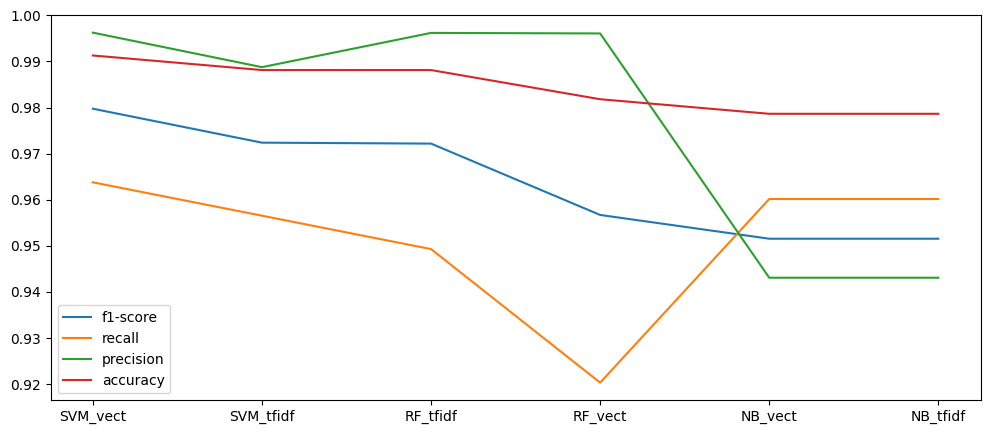

In [17]:
# Plotting the result
Name = ['SVM_vect', 'SVM_tfidf', 'RF_tfidf', 'RF_vect', 'NB_vect', 'NB_tfidf']
f, ax = plt.subplots(1, figsize=(12,5))
plt.plot(Name, total_results)
plt.legend(["f1-score", "recall", "precision", 'accuracy'], loc ="lower left")
plt.show()